In [1]:
import sys
%matplotlib inline
import pylab as plb
from tqdm import tqdm
import numpy as np
import mountaincar
from IPython.display import Image
from matplotlib import pyplot as plt

In [21]:
class SARSAEligibilityAgent():
    """
    A SARSA + eligibility trace agent for Mountain Car task
    """

    def __init__(self, mountain_car = None, x_linspace = (-150, 30, 20),
                v_linspace = (-15, 15, 20), w = None, tau = 1, gamma = 0.95,
                 eta = 0.001, lambda_ = 0.95):
        ''' Initialize the object '''
        
        # saving the environment object
        if mountain_car is None:
            self.mountain_car = mountaincar.MountainCar()
        else:
            self.mountain_car = mountain_car
        
        # range for x neurons grid
        self.x_values = np.linspace(*x_linspace)

        # range for v neurons grid
        self.v_values = np.linspace(*v_linspace)

        # steps x and v
        self.delta_x = self.x_values[1] - self.x_values[0]
        self.delta_v = self.v_values[1] - self.v_values[0]

        # sigmas x and v
        self.sigma_x = np.array([self.delta_x] * len(self.x_values))
        self.sigma_v = np.array([self.delta_v] * len(self.v_values))

        # number of actions
        self.n_actions = 3

        # number of neurons
        self.n_neurons = len(self.x_values) * len(self.v_values)

        # weight matrix
        if w is None:
            #self.w = np.random.randn(self.n_actions, self.n_neurons)
            self.w = np.zeros((self.n_actions, self.n_neurons))
        else:
            self.w = w

        # sampling softmax temperature
        self.tau = tau
        
        # reward discount factor
        self.gamma = gamma
        
        # learning rate
        self.eta = eta
        
        # eligibility trace parameter
        self.lambda_ = lambda_

    def r(self, x, v):
        ''' get neuron activations for s = (x, v) '''
        # x in rows, v in columns
        part_x = np.reshape(np.divide((self.x_values - x) ** 2, self.sigma_x ** 2), (-1, 1))
        part_v = np.reshape(np.divide((self.v_values - v) ** 2, self.sigma_v ** 2), (1, -1))
        return np.exp(-(part_x + part_v))

    def get_Q(self, x, v):
        ''' Get Q-function at given s = (x, v) with weights w '''
        
        return np.reshape(self.w @ np.reshape(self.r(x, v), (-1, 1)), (-1,))
    
    def get_Q_matrix(self):
        ''' Returns matrices indexed by (x, v) with values argmax Q and max Q '''
        
        result_index = np.zeros((len(self.x_values), len(self.v_values)))
        result_value = np.zeros((len(self.x_values), len(self.v_values)))
        for i, x in enumerate(self.x_values):
            for j, v in enumerate(self.v_values):
                Q = self.get_Q(x, v)
                result_index[i, j] = np.argmax(Q)
                result_value[i, j] = np.max(Q)
        return result_index, result_value
    
    def plot_Q_matrix(self):
        ''' Plot vector field action(x, v) '''
        
        A, V = self.get_Q_matrix()
        
        plt.figure()
        plt.title('Action selection')
        plt.xlabel('$x$')
        plt.ylabel('$\dot{x}$')
        plt.xlim((np.min(self.x_values) * 1.1, np.max(self.x_values) * 1.1))
        plt.ylim((np.min(self.v_values) * 1.1, np.max(self.v_values) * 1.1))
        for i, x in enumerate(self.x_values):
            for j, v in enumerate(self.v_values):
                action = A[i, j]
                value = V[i, j]
                if action == 1:
                    plt.scatter(x, v, 3, c = 'black')
                else:
                    direction = action - 1
                    plt.arrow(x, v, 3 * direction, 0, head_width=0.5, head_length=1, color = 'red' if direction < 0 else 'green')

    def get_action_probas(self, Q):
        ''' get action probabilities as a vector '''

        vector = np.exp(Q / self.tau)
        return vector / np.sum(vector)

    def get_action_index(self, x, v, greedy = False):
        ''' Sample action for s = (x, v) and weights w with parameter tau '''

        Q = self.get_Q(x, v)
        action_probas = self.get_action_probas(Q)
        if greedy: return np.argmax(action_probas)
        return np.random.choice(range(self.n_actions), p = action_probas)

    def update_w(self, x, v, a_index, delta):
        ''' Perform gradient descent on Q(s, a) by delta given s and a'''
        
        dQ_dwa = np.reshape(self.r(x, v), -1)
        self.w[a_index, :] += delta * dQ_dwa

    def visualize_trial(self, n_steps = 200):
        """Do a trial without learning, with display.

        Parameters
        ----------
        n_steps -- number of steps to simulate for
        """
        
        # prepare for the visualization
        plb.ion()
        mv = mountaincar.MountainCarViewer(self.mountain_car)
        mv.create_figure(n_steps, n_steps)
        plb.draw()
        plb.pause(1e-3)
            
        # make sure the mountain-car is reset
        self.mountain_car.reset()
        
        for n in (range(n_steps)):
            print('\rt =', self.mountain_car.t)
            sys.stdout.flush()
            
            # get current state
            s = (self.mountain_car.x, self.mountain_car.x_d)

            # selection current action based on softmax
            action_index = self.get_action_index(*s, greedy = True)
            
            # perform the action
            self.mountain_car.apply_force(action_index - 1)
            
            # simulate the timestep
            self.mountain_car.simulate_timesteps(100, 0.01)

            # update the visualization
            mv.update_figure()
            plb.draw()
            plb.pause(1e-3)
            
            # check for rewards
            if self.mountain_car.R > 0.0:
                print("\rreward obtained at t = ", self.mountain_car.t)
                break

    def learn(self, max_steps = 1000, use_tqdm = False):
        """Do a trial with learning, with no display.

        Parameters
        ----------
        n_steps -- number of steps to simulate for
        """
            
        # make sure the mountain-car is reset
        self.mountain_car.reset()

        # saved previous state
        old_s = None
        old_a = None
        
        # all states and actions array
        all_s_a = []
        
        # is finished
        finished = False
        
        # conditional tqdm
        tqdm_obj = []
        if use_tqdm:
            tqdm_obj = tqdm(total = max_steps)
            
        # loop over states
        for n in range(max_steps):
            # get current state
            s = (self.mountain_car.x, self.mountain_car.x_d)

            #print('\rt =', s, self.mountain_car.t, self.get_action_index(*s))
            sys.stdout.flush()

            # selection current action based on softmax
            action_index = self.get_action_index(*s)

            # save s, a
            all_s_a.append((s, action_index))

            # perform the action
            self.mountain_car.apply_force(action_index - 1)

            # simulate the timestep
            self.mountain_car.simulate_timesteps(100, 0.01)

            # check for rewards (runs at the end once)
            if self.mountain_car.R > 0.0:
                # print the obtained reward
                #print("reward obtained at t = " + str(self.mountain_car.t))

                # compute vector [xi ^ (T-1), ..., 1] where xi = gamma * lambda
                eligibility_trace = np.flip(np.array([self.gamma * self.lambda_]) **
                                            np.arange(len(all_s_a)), axis = 0)

                # compute the update for the Q function
                # update = eta * delta (from lectures)

                # old Q
                Q = self.get_Q(*old_s)[old_a]

                # new Q
                Q1 = np.max(self.get_Q(*s))

                # eta * (R + gamma * Qnew - Qold)
                update = self.eta * (self.mountain_car.R + self.gamma * Q1 - Q)

                # loop over history
                i = 0 
                for s0, a0 in all_s_a:
                    # updating Q based on SARSA and eligibility traces
                    self.update_w(s0[0], s0[1], a0, update * eligibility_trace[i])
                    i += 1

                # no steps after the reward
                finished = True
    
                if use_tqdm:
                    pbar.update()
                    pbar.set_postfix(info = 'Reward obtained')
                return n

            # saving old state
            old_s = s 
            old_a = action_index
                
            if use_tqdm:
                pbar.update()

        #if not finished:
        #    print('No reward')
        return max_steps + 1

Training the agent

In [ ]:
def get_learning_curve(title, iterations = 50, max_steps = 1000, **kwargs):
    # create an agent
    agent = SARSAEligibilityAgent(**kwargs)

    # array for training curve
    training_loss = []
    
    !rm train_*.png

    # number of iterations with reward
    finished = 0
    
    # learning
    with tqdm(total = iterations) as pbar:
        for i in range(iterations):
            result = agent.learn(max_steps)
            if result >= max_steps + 1:
                result = 0
            training_loss.append(result)
            if result > 0:
                agent.plot_Q_matrix()
                plt.title('Training %s, iteration %d' % (title, i))
                plt.savefig('train_%05d.png' % i, bbox_inches = 'tight')
                plt.close()
                finished += 1
                pbar.set_postfix(with_reward = finished, with_reward_percent = round(100 * finished / (i + 1)))
            pbar.update(1)
        
    # creating a gif
    !convert -delay 15 -loop 0 train*.png train_{title}.gif

    # displaying it
    with open('train_%s.gif' % title, 'rb') as f:
        display(Image(f.read()))
    
    return training_loss, agent

In [ ]:
num_agents = 20
np.random.seed(43)
results = [get_learning_curve('agent_%dof%d' % (i + 1, num_agents), iterations = 100, max_steps = 1000,
                              tau = 0.001, gamma = 0.99, eta = 0.001, lambda_ = 0.99)
           for i in range(num_agents)]

rm: cannot remove 'train_*.png': No such file or directory


 28%|██▊       | 28/100 [01:01<02:13,  1.86s/it, with_reward=28, with_reward_percent=100]

Plotting the learning curve

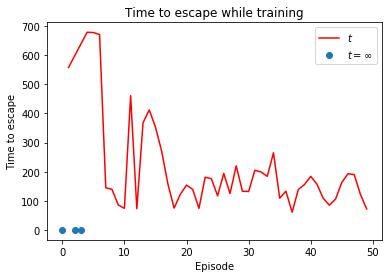

In [116]:
#%matplotlib inline
# Plot the learning curve
plt.title('Time to escape while training')
plt.xlabel('Episode')
plt.ylabel('Time to escape')
training_loss = np.array(training_loss)
idx = np.where(training_loss > 0)[0]
bad_idx = np.where(training_loss <= 0)[0]
plt.plot(idx, training_loss[idx], 'r', label = '$t$')
plt.plot(bad_idx, training_loss[bad_idx], 'o', label = '$t=\infty$')
plt.legend()
plt.show()

Demonstrating one episode

In [111]:
# Visualize one episode
%matplotlib qt5
agent.visualize_trial()

t = 0.0
t = 1.0
t = 2.0
t = 3.0
t = 4.0
t = 5.0
t = 6.0
t = 7.0
t = 8.0
t = 9.0
t = 10.0
t = 11.0
t = 12.0
t = 13.0
t = 14.0
t = 15.0
t = 16.0
t = 17.0
t = 18.0
t = 19.0
t = 20.0
t = 21.0
t = 22.0
t = 23.0
t = 24.0
t = 25.0
t = 26.0
t = 27.0
t = 28.0
t = 29.0
t = 30.0
t = 31.0
t = 32.0
t = 33.0
t = 34.0
t = 35.0
t = 36.0
t = 37.0
t = 38.0
t = 39.0
t = 40.0
t = 41.0
t = 42.0
t = 43.0
t = 44.0
t = 45.0
t = 46.0
t = 47.0
t = 48.0
t = 49.0
t = 50.0
t = 51.0
t = 52.0
t = 53.0
t = 54.0
t = 55.0
t = 56.0
t = 57.0
t = 58.0
t = 59.0
t = 60.0
t = 61.0
t = 62.0
t = 63.0
t = 64.0
t = 65.0
t = 66.0
t = 67.0
t = 68.0
t = 69.0
t = 70.0
t = 71.0
t = 72.0
t = 73.0
t = 74.0
t = 75.0
t = 76.0
t = 77.0
t = 78.0
t = 79.0
t = 80.0
t = 81.0
t = 82.0
t = 83.0
t = 84.0
t = 85.0
t = 86.0
t = 87.0
t = 88.0
t = 89.0
t = 90.0
reward obtained at t =  91.0


In [57]:
from matplotlib.animation import FuncAnimation

# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)
if len(sys.argv) > 1 and sys.argv[1] == 'save':
    anim.save('line.gif', dpi=80, writer='imagemagick')
else:
    # plt.show() will just loop the animation forever.
    plt.show()